In this Notebook we combine everything we have learned to create a model that can create good embeddings on a very small train-dataset. And later perform zero-shot predictions on a subset of images from the same domain.

In [26]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import transforms
from torchvision.transforms import RandAugment
import torchdatasets as td
from tqdm import tqdm

from modules.losses import SupConLoss
from modules.backbones import Swin
from modules.datasets import MultiLabelDataset,AugmentingDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from modules.trainer import Trainer

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/putting_it_all_together"

In [27]:
dataset = MultiLabelDataset(
    "./Carparts",
    transform=None,
    max_size_per_class=250,
    label_index=1
    )
len(dataset)

2000

In [28]:
ZERO_SHOT_LABELS = ["Air intake","Dashboard","Tail light","Gear stick"] #these will be excluded from training
AUGMENTING_FACTOR = 16

zero_shot_datasets = {}
train_datasets = {}

for key in dataset.datasets:
    if key in ZERO_SHOT_LABELS:
        zero_shot_datasets[key] = dataset.datasets[key]
    else:
        train_datasets[key] = dataset.datasets[key]
   


necessary_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

def augment_datasets(datasets):
    train_sets = []
    val_sets = []
    for key in datasets:
        subset = datasets[key]
        #Use 20 Images for Training
        train_dataset, val_dataset = torch.utils.data.random_split(subset, [20, 250-20],generator=torch.Generator().manual_seed(42))
        train_dataset = AugmentingDataset(train_dataset,RandAugment(),transforms=necessary_transforms,factor=AUGMENTING_FACTOR)
        val_dataset = td.datasets.WrapDataset(val_dataset)
        val_dataset.map(td.maps.To(necessary_transforms,0))
        train_sets.append(train_dataset)
        val_sets.append(val_dataset)
    
    return ConcatDataset(train_sets),ConcatDataset(val_sets)

train_set, val_set = augment_datasets(train_datasets)
zero_shot_embedding,zero_shot_val = augment_datasets(zero_shot_datasets)
len(train_set)

1280

In [29]:
BATCH_SIZE = 32
train_loader =  DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, pin_memory=True)

In [30]:
#Build the model
EMBEDDING_SIZE = 1024
model = ContrastiveNetwork(Swin(pretrained=True,freeze=False,embedding_size=EMBEDDING_SIZE),SupConLoss())

In [31]:
#Train the  model
EPOCHS = 5

model_dir = os.path.join(SAVE_DIR,"swin")
if not os.path.isdir(model_dir):
    os.makedirs(model_dir,exist_ok=True)
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    trainer = Trainer(max_epochs=EPOCHS,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=model, train_dataloaders=train_loader)
    lossTracker.save(model_dir)
    

In [32]:
model = Swin(embedding_size=EMBEDDING_SIZE)
model.load_state_dict(torch.load(os.path.join(SAVE_DIR,"swin","checkpoints",f"epoch_{EPOCHS-1}.pth")))
model = model.to(DEVICE)

In [33]:
from modules.knn import KNN

knn = KNN(model,train_loader,os.path.join(SAVE_DIR,"trained"))

In [34]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(val_loader):
        img,label = batch
        embedding = model(img.to(DEVICE)).cpu().numpy()
        embeddings.append(embedding)  
        labels.append(label)
        
embeddings = np.vstack(embeddings)     
labels = np.vstack(labels).reshape(-1)

100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


In [35]:
from sklearn.metrics import f1_score

predictions = knn.querry_labels(embeddings)
print(f"F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

F1-Score: 0.995


In [36]:
zero_shot_val_loader = DataLoader(zero_shot_val, batch_size=BATCH_SIZE, pin_memory=True)
zero_shot_embeddings = []
zero_shot_labels = []

with torch.no_grad():
    for batch in tqdm(zero_shot_val_loader):
        img,label = batch
        embedding = model(img.to(DEVICE)).cpu().numpy()
        zero_shot_embeddings.append(embedding)  
        zero_shot_labels.append(label)
        
zero_shot_embeddings = np.vstack(zero_shot_embeddings)     
zero_shot_labels = np.vstack(zero_shot_labels).reshape(-1)

100%|██████████| 29/29 [00:08<00:00,  3.36it/s]


In [37]:

zero_shot_embedding_loader = DataLoader(zero_shot_embedding, batch_size=BATCH_SIZE, pin_memory=True)
zero_shot_knn = KNN(model,zero_shot_embedding_loader,os.path.join(SAVE_DIR,"zero_shot"))

predictions = zero_shot_knn.querry_labels(zero_shot_embeddings)
print(f"F1-Score: {f1_score(predictions,zero_shot_labels,average='macro'):.3f}")


F1-Score: 0.975


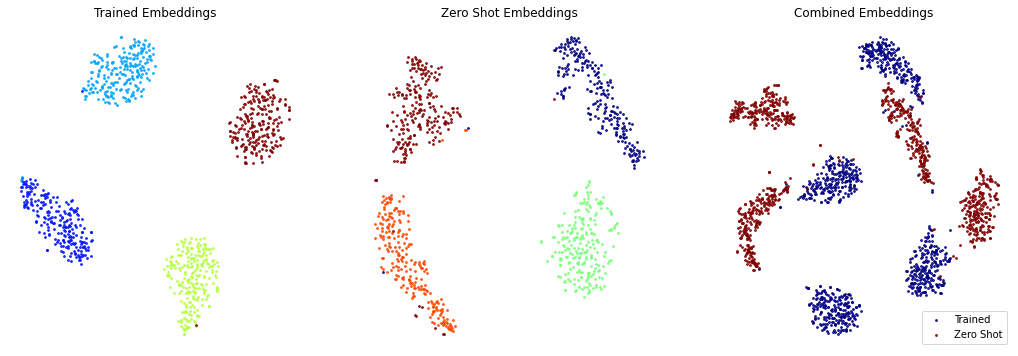

In [39]:
import matplotlib.pyplot as plt
from modules.plotting import plot_tsne

fig = plt.figure(figsize=(6*3,6))

plt.subplot(1,3,1)
plot_tsne(embeddings,labels)
plt.title("Trained Embeddings")
plt.axis("off")

plt.subplot(1,3,2)
plot_tsne(zero_shot_embeddings,zero_shot_labels)
plt.title("Zero Shot Embeddings")
plt.axis("off")

combined_embeddings = np.vstack([embeddings,zero_shot_embeddings])
#combined_labels = np.hstack([labels,zero_shot_labels])

combined_labels = np.hstack([np.zeros(labels.shape,dtype=int) ,np.ones(zero_shot_labels.shape,dtype=int)])
plt.subplot(1,3,3)
plot_tsne(combined_embeddings,combined_labels)
plt.title("Combined Embeddings")
plt.axis("off")
plt.legend(["Trained","Zero Shot"],loc=4)

plt.savefig(f'plots/final.png', bbox_inches='tight')
plt.show()